# **Lab 4. LLM Quantization with AWQ**

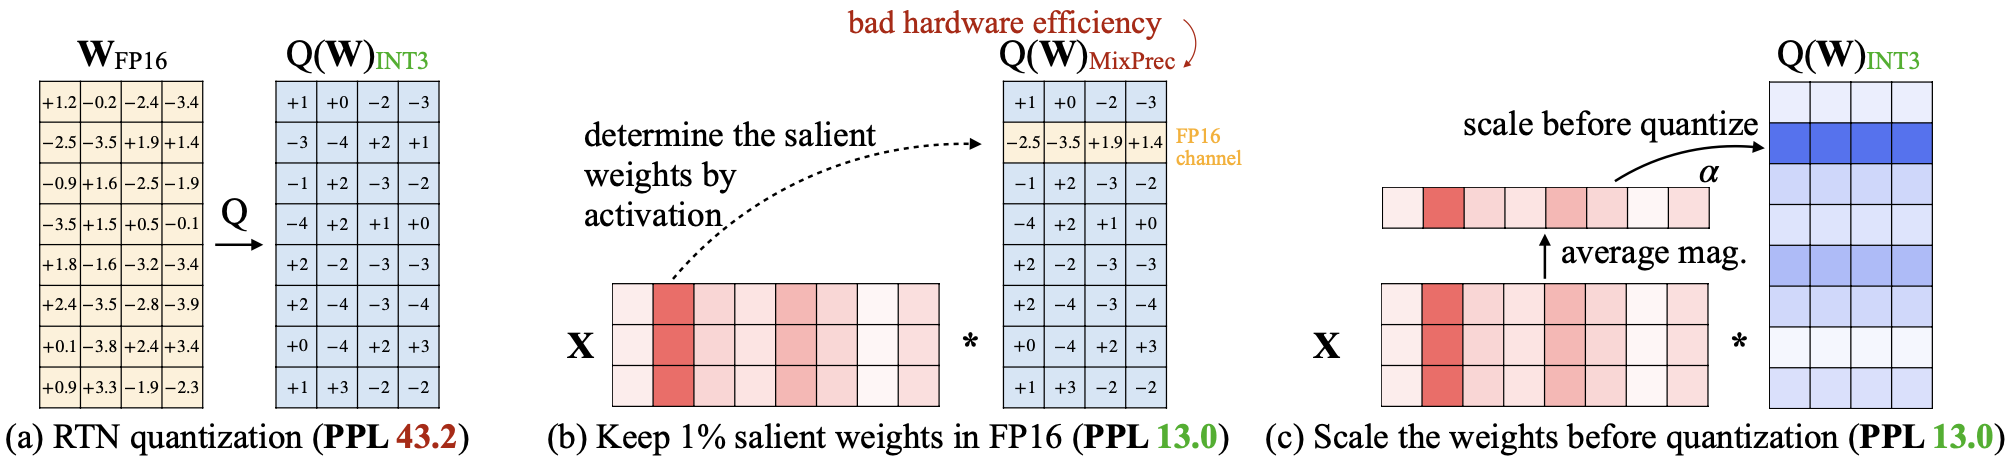

There are two types of quantization:

- Quantize both weight and activation
    - Better for computation-bounded scenarios: context stage, large batch inference
    - For example, SmoothQuant: W8A8 quantization
- Weight-only quantization
    - Better for memory-bounded scenarios: decoding stage, single batch inference
    - For example, AWQ that will be introduced in this lab: W4A16 quantization

For the LLaMA-65B model, in the decoding stage of single batch inference, we need to perform GEMV $[1, 8192] \times [8192, 8192]$. Taking the NVIDIA A100 80G as an example, its half-precision (FP16) performance is 312TFLOPS, and the memory bandwidth is about 2000GB/s. Therefore, its computation intensity is:

$$
\frac{\text{FLOP}}{\text{Byte}} = \frac{2\times 8192^2}{8192^2} << \frac{3.12\times 10^{11}}{2\times 10^9}
$$

This is very memory-bounded (~$10^2$ gap), which is why we need low-bit weight quantization.

## 0. Setup

In [1]:
%pip install transformers==4.31.0 accelerate==0.21.0 sentencepiece==0.1.99 tokenizers==0.13.3 datasets==2.15.0 tqdm zstandard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 KB 6.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 KB 12.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 KB 14.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 KB 10.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 791.7/791.7 KB 16.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import gc
import tqdm
import torch
import torch.nn as nn

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from functools import partial

In [2]:
def get_model_size(model: nn.Module, data_width=16, group_size=-1):
    '''
        calculate the model size
    '''

    # scale and zero points for per-group quantization
    if group_size != -1:
        data_width += (16 + 4) / group_size
    
    # number of parameters
    n_elements = 0
    for param in model.parameters():
        n_elements += param.numel()
    
    return n_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [3]:
# load the model
model_path = "facebook/opt-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Evaluation

Here we use **Perplexity** metrics and wikitext-2 dataset for evaluation. 

$$PPL = e^{\frac{1}{N}\sum_{i=1}^{N} \text{Loss}_i}$$

In [4]:
def evaluate(model, tokenizer):
    # load and tokenize the raw dataset
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer('\n\n'.join(testenc['text']), return_tensors='pt')

    nsamples = 40
    testenc = testenc.input_ids.to(model.device)
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        # extract input sequence, chunk for 2048 (max context length)
        batch = testenc[:, i * 2048: (i + 1) *  2048].to(model.device)

        # calculate logits
        with torch.no_grad():
            logits = model(batch).logits

        # last token (not in labels) need to be eliminated
        shift_logits = logits[:, :-1, :].contiguous().float()

        # first token (not in logits) need to be eliminated
        shift_labels = testenc[:, (i * 2048):((i + 1) *  2048)][:, 1:]

        # calculate loss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        # calculate total negative log likehood
        negative_log_likehood = loss.float() * 2048
        nlls.append(negative_log_likehood)
    
    # return the perplexity
    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))

In [ ]:
# evaluate fp32 model
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=32, group_size=-1)

print(f"\nmodel perplexity: {perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializa


model perplexity: 14.47
model size: 5019.22 MiB


## 2. Pseudo Quantization

Pseudo Quantization is used to simulate the effects of quantization on a model without actually quantizing the model's weights. (i.e. rounding to the nearest quantized value and then dequantizing back to a float.)

Uniform quantization is to map real values in the range $[\beta, \alpha]$ to lie within $[0, 2^{b} - 1]$.

\begin{equation}
s_q = \frac{\alpha - \beta}{2^{b} - 1} \tag{1},
\end{equation}

\begin{equation}
z = -\text{Round}(\beta * scale) \tag{2}
\end{equation}

\begin{equation}
w_q = \text{Clamp}(\text{Round}(\frac{w}{s_q}) + z) \tag{3},
\end{equation}



In [5]:
def pseudo_quantize_tensor(w, n_bit=4, q_group_size=-1):
    ori_w_shape = w.shape
    
    # per-group quantization
    if q_group_size > 0:
        assert ori_w_shape[-1] % q_group_size == 0
        w = w.reshape(-1, q_group_size)
    
    assert w.dim() == 2

    # calcuate the max and min values
    max_val = w.amax(dim=1, keepdim=True)
    min_val = w.amin(dim=1, keepdim=True)
    
    assert max_val.dim() == 2 and max_val.size(0) == w.size(0) and max_val.size(1) == 1
    assert min_val.dim() == 2 and min_val.size(0) == w.size(0) and min_val.size(1) == 1

    # calculate the scale factor and zero point
    max_int = 2 ** n_bit - 1
    scales = (max_val - min_val).clamp(min=1e-5) / max_int
    zeros = (-torch.round(min_val / scales)).clamp_(0, max_int)

    assert scales.shape == max_val.shape and scales.shape == min_val.shape
    assert torch.isnan(scales).sum() == 0
    assert torch.isnan(w).sum() == 0

    # quantize weight (formula 3)
    w = torch.clamp(torch.round(w / scales) + zeros, 0, max_int)
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    # dequantize weight (inverse transformation)
    w = (w - zeros) * scales
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size
    assert torch.isnan(w).sum() == 0
    
    w = w.reshape(ori_w_shape)
    return w

In [6]:
@torch.no_grad()
def pseudo_quantize_model(model, w_bit, q_group_size):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

In [ ]:
# free the memory
del model
gc.collect()
torch.cuda.empty_cache()

# quantize the model weight
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model(model, w_bit=3, q_group_size=128)

# evaluate
perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

NameError: name 'model' is not defined

## 3. Salient Weight Cahnnel

There is a observation in LLM activations that **outliers appear in a small fraction of the channels**. If one channel has an outlier, it **persistently appears in all tokens**. The variance amongst the channels for a given token is large (the activations in some channels are very large, but most are small), but the variance between the magnitudes of a given channel across tokens is small (outlier channels are consistently large).

According to the observation of AWQ, weight channels corresponding to activation outliers are more salient, and preserving those salient weights can lead to a significant performance improvement. Next, let's try to find the salient weights and retain them as original values to observe the change in perplexity.

### Calibration Dataset

The following code is used to load the calibration dataset, so as to obtain activation outliers to identify salient weights.

In [6]:
def get_calib_dataset(tokenizer, n_samples=256, block_size=512):
    # load datasets
    dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
    dataset = dataset.shuffle(seed=42)

    # extract samples from dataset
    samples = []
    n_run = 0
    for data in dataset:
        line = data["text"]
        line = line.strip()
        
        line_encoded = tokenizer.encode(line)
        if len(line_encoded) > block_size:
            continue

        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        
        samples.append(sample)
        n_run += 1
        if n_run == n_samples: break
    
    # concatenate all samples and split according to block size
    cat_samples = torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")

    return [
        cat_samples[:, i * block_size: (i + 1) * block_size]
        for i in range(n_split)
    ]

In [39]:
samples = get_calib_dataset(tokenizer)
print(f"    # samples: {len(samples)}")
print(f"    # tokens per sample: {samples[0].shape[1]}")

Repo card metadata block was not found. Setting CardData to empty.


 * Split into 127 blocks
    # samples: 127
    # tokens per sample: 512


In [7]:
@torch.no_grad()
def get_calib_feat(model, tokenizer):
    input_dict = dict()

    def stat_input_max_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]

        # calculate mean value of input activation per channel
        x_max = x.view(-1, x.shape[-1]).abs().mean(dim=0).cpu().detach()
        if name not in input_dict:
            input_dict[name] = [x_max]
        else:
            input_dict[name] += [x_max]

    # register a hook after the forward pass
    hooks = []
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            hooks.append(
                m.register_forward_hook(
                    partial(stat_input_max_hook, name=name)
                )
            )

    print("Collecting activation scales...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    samples = get_calib_dataset(tokenizer)

    # inference over the calibration samples
    for input_ids in tqdm.tqdm(samples):
        input_ids = input_ids.to(device)
        model(input_ids)
    
    # clear the hook
    for hook in hooks:
        hook.remove()

    return input_dict

In [8]:
# free the memory
del model
gc.collect()
torch.cuda.empty_cache()

# get input features
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
input_feat = get_calib_feat(model, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

Repo card metadata block was not found. Setting CardData to empty.


 * Split into 127 blocks


100%|██████████| 127/127 [00:32<00:00,  3.93it/s]


### Comparative Study

We will investigate the impact of protecting highly important (salient) weight channels versus randomly selected channels during post-training quantization (PTQ). The goal is to demonstrate that model performance, specifically measured by Perplexity (PPL), is highly sensitive to the preservation of a small fraction (1%) of the most salient weights.

#### Question 1

- Add codes before and after the quantization to protect 1% of the salient weight channels (1% channels with highest importance), ensuring that their values remain unchanged after quantization. (The desired perplexity is 17.15)

- Randomly protect 1% of the weight channels, ensuring that their values remain unchanged after quantization, and then observe the perplexity. (The desired perplexity is over 100)

- Provide a possible explanation for why the salient weight channels are so important.

In [9]:
@torch.no_grad()
def pseudo_quantize_model_salient_weight_fp16(
    model, w_bit, q_group_size, input_feat
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()
            
            # find salient weight channels
            outlier_indices = torch.topk(importance, k=int(importance.size(0) * 0.01)).indices
            assert outlier_indices.dim() == 1

            # backup
            outlier = m.weight.data[:, outlier_indices].clone()

            # quantize
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            # restore
            m.weight.data[:, outlier_indices] = outlier

In [15]:
# free the memory
del model
gc.collect()
torch.cuda.empty_cache()

# quantize the model weight
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_salient_weight_fp16(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# evaluate
perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [02:28<00:00,  3.72s/it]



model perplexity: 17.15
model size: 495.06 MiB


In [10]:
@torch.no_grad()
def pseudo_quantize_model_random_weight_fp16(
    model, w_bit, q_group_size, input_feat
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            # randomly choose
            outlier_mask = torch.randperm(importance.size(0)) < int(importance.size(0) * 0.01)
            assert outlier_mask.dim() == 1

            # backup
            outlier = m.weight.data[:, outlier_mask].clone()

            # quantize
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            # restore
            m.weight.data[:, outlier_mask] = outlier

In [59]:
# free the memory
del model
gc.collect()
torch.cuda.empty_cache()

# quantize the model weight
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_random_weight_fp16(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# evaluate
perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializa


model perplexity: 191.74
model size: 495.06 MiB


**Answer**

위의 실험을 통해 **activation**의 outlier 값을 기준으로 salient channels을 선정하는 것이 random하게 선정하는 것에 비해 유리하다는 것을 확인할 수 있습니다. \
random하게 선정하는 경우, outlier channel과 곱해지는 weight이 양자화되는 경우가 존재하며 이는 작은 오차도 큰 값으로 작용하여 큰 폭의 성능 하락을 일으키게 됩니다.

## 4. Activation-aware Weight Quantization

Despite keeping 0.1% of weights in FP16 can improve the quantized performance without a noticeable increase in model size (measured in total bits), such a mixed-precision data type will make the system implementation difficult. We need to come up with a method to protect the important weights without actually keeping them as FP16.

### Activation-aware Scaling

According to the methodology of AWQ, simply scaling up the salient weight channels can protect them. The principle is as follows:

- Consider a linear layer channel $\mathbf{y} = \mathbf{w}x$ (from $\mathbf{W}x$). We care about the quantization error from $Q(\mathbf{w})x$.

- $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$, $Δ = \frac{\max(|w|)}{2^{N - 1}}$.
- The scaled version is $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$.
- The $RoundErr$ is always ~0.25 (average from 0-0.5).
- When the group size is relatively large (e.g., 128), scaling up one channel usually does not increase the maximum value in a group (i.e. $Δ$ remains unchanged).
- Thus, $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$ < $Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x = Err(Q(\mathbf{w}) x)$.

#### Question 2

- Write code to scale up the salient weight channels, then quantize it, and finally scale it back down, and observe the changes in perplexity. (The desired perplexity is 18.93)

- Try different scale factors (e.g. 1, 2, 3, and 4) in the code and observe the changes in perplexity. Did you observe the perplexity first decreasing and then increasing? Please explain why this would happen based on the principle mentioned above.

In [24]:
@torch.no_grad()
def pseudo_quantize_model_weight_scaleup(
    model, w_bit, q_group_size, input_feat, scale_factor
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            # find salient wegiht channels
            outlier_mask = torch.topk(importance, k=int(importance.size(0) * 0.01)).indices
            assert outlier_mask.dim() == 1

            # apply the scale factor
            m.weight.data[:, outlier_mask] *= scale_factor

            # quantize
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            # scale back
            m.weight.data[:, outlier_mask] /= scale_factor

In [16]:
# free the memory
del model
gc.collect()
torch.cuda.empty_cache()

# quantize the model weight
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=2)

# evaluate
perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializa


model perplexity: 18.93
model size: 495.06 MiB


*EXP. scale별 perplexity (model_size는 동일)*

In [18]:
for s in torch.arange(1, 2, 0.1):
    # free the memory
    del model
    gc.collect()
    torch.cuda.empty_cache()

    # quantize the model weight
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
    pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=s)

    # evaluate
    perplexity = evaluate(model, tokenizer)
    print(f"scale: {s}")
    print(f"model perplexity: {perplexity:.2f}")
    

evaluating...: 100%|██████████| 40/40 [02:24<00:00,  3.61s/it]


scale: 1.0
model perplexity: 121.90


evaluating...: 100%|██████████| 40/40 [02:24<00:00,  3.62s/it]


scale: 1.100000023841858
model perplexity: 47.12


evaluating...: 100%|██████████| 40/40 [02:20<00:00,  3.51s/it]


scale: 1.2000000476837158
model perplexity: 30.96


evaluating...: 100%|██████████| 40/40 [02:20<00:00,  3.51s/it]


scale: 1.2999999523162842
model perplexity: 25.90


evaluating...: 100%|██████████| 40/40 [02:21<00:00,  3.55s/it]


scale: 1.399999976158142
model perplexity: 21.14


evaluating...: 100%|██████████| 40/40 [02:21<00:00,  3.54s/it]


scale: 1.5
model perplexity: 20.19


evaluating...: 100%|██████████| 40/40 [02:24<00:00,  3.62s/it]


scale: 1.600000023841858
model perplexity: 19.71


evaluating...: 100%|██████████| 40/40 [02:24<00:00,  3.62s/it]


scale: 1.7000000476837158
model perplexity: 19.01


evaluating...: 100%|██████████| 40/40 [02:25<00:00,  3.65s/it]


scale: 1.7999999523162842
model perplexity: 18.97


evaluating...: 100%|██████████| 40/40 [02:25<00:00,  3.64s/it]


scale: 1.899999976158142
model perplexity: 18.89


In [19]:
for s in torch.arange(2, 3.1, 0.1):
    # free the memory
    del model
    gc.collect()
    torch.cuda.empty_cache()

    # quantize the model weight
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
    pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=s)

    # evaluate
    perplexity = evaluate(model, tokenizer)
    print(f"scale: {s}")
    print(f"model perplexity: {perplexity:.2f}")
    

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializa

scale: 2.0
model perplexity: 18.93


evaluating...: 100%|██████████| 40/40 [02:26<00:00,  3.67s/it]


scale: 2.0999999046325684
model perplexity: 18.86


evaluating...: 100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


scale: 2.200000047683716
model perplexity: 19.00


evaluating...: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


scale: 2.299999952316284
model perplexity: 18.96


evaluating...: 100%|██████████| 40/40 [02:08<00:00,  3.21s/it]


scale: 2.4000000953674316
model perplexity: 18.97


evaluating...: 100%|██████████| 40/40 [02:09<00:00,  3.25s/it]


scale: 2.5
model perplexity: 19.20


evaluating...: 100%|██████████| 40/40 [02:10<00:00,  3.27s/it]


scale: 2.5999999046325684
model perplexity: 18.91


evaluating...: 100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


scale: 2.700000047683716
model perplexity: 19.03


evaluating...: 100%|██████████| 40/40 [02:08<00:00,  3.20s/it]


scale: 2.799999952316284
model perplexity: 18.90


evaluating...: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


scale: 2.9000000953674316
model perplexity: 19.12


evaluating...: 100%|██████████| 40/40 [02:09<00:00,  3.25s/it]


scale: 3.0
model perplexity: 19.25


**Answer**

위의 실험 결과를 통해 scale factor가 증가함에 따라 perplexity가 점차 감소하다가 그 이후에는 증가하는 것을 확인할 수 있습니다.

- ```1.0 ~ 2.1``` : activation 중 outlier channel에서 발생하는 quantization error를 scale로 나누어주는 효과
- ```2.1 ~ 3.0``` : quantization해야 할 weight의 범위가 커지면서 전체적인 quantization error 증가

### Find Optimal Scale

Due to the instability of fine-tuning, it would be a better choice to find the optimal  s  within a predefined search space. We can find the optimal scale in the search space to protect the salient weights while also considering other values. In practice, it can be observed that considering just the activations is sufficient to yield good results.

In [9]:
@torch.no_grad()
def scale_ln_fcs(ln, fcs, scales):
    '''
        scale fusion for LN to FC (QKV or FC)
    '''
    if not isinstance(fcs, list):
        fcs = [fcs]
    scales = scales.to(ln.weight.device)

    # activation: divide by scale
    ln.weight.div_(scales)
    if hasattr(ln, 'bias') and ln.bias is not None:
        ln.bias.div_(scales)
    
    # weight: multiply by scale
    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))
    
    # sanity check
    for p in ln.parameters():
        assert torch.isnan(p).sum() == 0
    
    for fc in fcs:
        for p in fc.parameters():
            assert torch.isnan(p).sum() == 0

In [10]:
@torch.no_grad()
def scale_fc_fc(fc1, fc2, scales):
    '''
        scale fusion for FC to FC
    '''
    assert isinstance(fc1, nn.Linear)
    assert isinstance(fc2, nn.Linear)

    scales = scales.to(fc1.weight.device)

    # activation: divide by scale
    fc1.weight[-scales.size(0):].div_(scales.view(-1, 1))
    if fc1.bias is not None:
        fc1.bias.div_(scales.view(-1))
    
    # weight: multiply by scale
    fc2.weight.mul_(scales.view(1, -1))

    # sanity check
    for p in fc1.parameters():
        assert torch.isnan(p).sum() == 0
    
    for p in fc2.parameters():
        assert torch.isnan(p).sum() == 0
    

In [13]:
# ln fusion test
ln = nn.LayerNorm(2048)
fc = nn.Linear(2048, 2048)

# dummy parameters
ln.weight.data.fill_(1.0)
ln.bias.data.fill_(0.0)
fc.weight.data.fill_(1.0)

# scaling
scales = torch.ones(2048) * 2.0
scale_ln_fcs(ln, fc, scales)

# output
print("LayerNorm")
print(f"    shape: {ln.weight.shape}, data: {ln.weight.data[0].item()}")
print("FC")
print(f"    shape: {fc.weight.shape}, data: {fc.weight.data[0, 0].item()}")

LayerNorm
    shape: torch.Size([2048]), data: 0.5
FC
    shape: torch.Size([2048, 2048]), data: 2.0


In [20]:
# fc fusion test
fc1 = nn.Linear(2048, 2048 * 4)
fc2 = nn.Linear(2048 * 4, 2048)

# dummy parameters
fc1.weight.data.fill_(1.0)
fc2.weight.data.fill_(1.0)

# scaling
scales = torch.ones(2048 * 4) * 2.0
scale_fc_fc(fc1, fc2, scales)

# output
print("FC1")
print(f"    shape: {fc1.weight.shape}, data: {fc1.weight.data[0, 0].item()}")
print("FC2")
print(f"    shape: {fc2.weight.shape}, data: {fc2.weight.data[0, 0].item()}")

FC1
    shape: torch.Size([8192, 2048]), data: 0.5
FC2
    shape: torch.Size([2048, 8192]), data: 2.0


#### Question 3

Please add the code for search and run it to observe the perplexity. (The desired perplexity is 17.92)

$$
𝐋(\mathbf{s})=\lVert Q(\mathbf{W}\cdot \mathbf{s})  (\mathbf{s^{-1}} \cdot \mathbf{X}) - \mathbf{W}\mathbf{X}  \rVert,  \quad\mathbf{s}= \mathbf{s_X}^{\alpha}
$$
$$
\mathbf{s}^* = \text{argmin}_{\mathbf{s}} 𝐋(\mathbf{s}),\quad \alpha^*=\text{argmin}_{\alpha} 𝐋(\mathbf{s_X}^{\alpha})
$$

In [11]:
@torch.no_grad()
def auto_scale_block(
    module, 
    name, 
    w_bit, 
    q_group_size, 
    input_feat
):
    # find best scale ratio
    def _search_module_scale(block, linear2scale: list, x, kwargs={}):
        # original output activation
        x = x.to(next(block.parameters()).device)
        with torch.no_grad():
            ori_out = block(x, **kwargs)
            if isinstance(ori_out, tuple):
                ori_out = ori_out[0]

        # calculate importance
        s_x = x.view(-1, x.shape[-1]).abs().mean(0)

        # initialize (# TODO)
        best_error = float('inf')
        best_alpha = -1
        best_scales = None

        # back up original parameters
        ori_sd = {k: v.cpu() for k, v in block.state_dict().items()}
        
        # grid search
        n_grid = 20
        history = []
        for alpha in range(n_grid):
            alpha = alpha / n_grid

            # calculate scales
            scales = torch.clamp(s_x, 1e-5).pow(alpha)
            assert scales.shape == s_x.shape
            
            # apply geomertric mean
            scales = scales / (scales.max() * scales.min()).sqrt().view(1, -1)

            for fc in linear2scale:
                scales = scales.to(fc.weight.device)

                # scale up
                fc.weight.mul_(scales)

                # quantize
                fc.weight.data = pseudo_quantize_tensor(fc.weight.data, w_bit, q_group_size)

                # scale back down
                fc.weight.div_(scales)

            # quantized output activation
            out = block(x, **kwargs)
            if isinstance(out, tuple):
                out = out[0]

            # calculate mse loss
            loss = (ori_out - out).float().pow(2).mean().item()
            history.append(loss)

            # update
            if loss < best_error:
                best_error = loss
                best_alpha = alpha
                best_scales = scales

            # restore original wegihts
            block.load_state_dict(ori_sd)

        # raise error
        if best_alpha == -1:
            print(history)
            raise Exception

        best_scales = best_scales.view(-1)
        assert torch.isnan(best_scales).sum() == 0, best_scales

        return best_scales.detach()
    
    # attention
    # input activation
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)
    qkv = [module.self_attn.q_proj, module.self_attn.k_proj, module.self_attn.v_proj]
    final_scales = _search_module_scale(module.self_attn, qkv, inp)
    scale_ln_fcs(module.self_attn_layer_norm, qkv, final_scales)

    # output activation
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)
    final_scales = _search_module_scale(module.self_attn.out_proj, [module.self_attn.out_proj], inp)
    scale_fc_fc(module.self_attn.v_proj, module.self_attn.out_proj, final_scales)

    # ffn
    # input activation
    inp = input_feat[name + '.fc1']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)
    final_scales = _search_module_scale(module.fc1, [module.fc1], inp)
    scale_ln_fcs(module.final_layer_norm, module.fc1, final_scales)

    # output activation     
    inp = input_feat[name + '.fc2']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)
    final_scales = _search_module_scale(module.fc2, [module.fc2], inp)
    scale_fc_fc(module.fc1, module.fc2, final_scales)

In [12]:
def pseudo_quantize_model_weight_auto_scale(model, w_bit, q_group_size, input_feat):
    from transformers.models.opt.modeling_opt import OPTDecoderLayer

    for name, module in model.named_modules():
        if isinstance(module, OPTDecoderLayer):
            auto_scale_block(module, name, w_bit, q_group_size, input_feat)
        
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)    

In [13]:
# free the memory
del model
gc.collect()
torch.cuda.empty_cache()

# quantize the model weight
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight_auto_scale(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# evaluate
perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [02:31<00:00,  3.78s/it]



model perplexity: 17.93
model size: 495.06 MiB


## 5. Additional Experiments

Any optimization techniques without mixed precision on your mind? Try to implement them to improve the perplexity further!